In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.simplefilter("ignore")
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [8, 4],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Multilevel regression (*hierarchical regression*)


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..

*  Chris Fonnesbeck, <a href="https://github.com/fonnesbeck/bayes_course_july2020">Bayesian Computing Course</a>
*  O. Martin, *Bayesian analysis with Python*, Ch. 3

# Hierarchical (or multilevel) modeling

* Hierarchical  or multilevel modeling is a generalization of regression modeling.

* *Multilevel models* are regression models whose  parameters are allowed to **vary by group**.

* This allows dealing with observations which are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling.

# Hierarchical (or multilevel) modeling

* A *hierarchical model* provides an intermediate approach between:
    * the *pooled model*, which merges the observations from all clusters, fitting a single model.  Yet, a single model might be  excessively constrained to accurately represent all clusters; 
    * the *unpooled model*, which fits an independent model to each cluster. Estimates are however unreliable on cluster containing few observations.
    
* The hierarchical approach is often more sensible than both.

# The radon data set (Gelman et al., 2007)

<img src='img/how_radon_enters.jpg' width=400 align="center" >

# The radon data set (Gelman et al., 2007)

* The amount of the radioactive gas radon has been measured among different households in all counties of several states.

* Radon gas is  the highest cause of lung cancer in non-smokers.

* It is believed to be more strongly present in households containing a basement; moreover, its presence depends on the  type of soil.

*  The  EPA has set an action level of 4 pCi/L. At or above this level of radon, the EPA recommends you take corrective measures to reduce your exposure to radon gas.

# Radon contamination in Minnesota

* We will model radon levels in Minnesota. 
* The EPA did the radon study  in 80,000 houses, measuring  two important covariates:

    * measurement in basement or first floor (radon higher in basements)
    * county uranium level (positive correlation with radon levels)

The hierarchy in this example is households within county. 

### Data organization

In [3]:
# Import radon data, 919 rows
radon_data = pd.read_csv('data/radon.csv', index_col=0)

#list of  counties in Minnesota (85 different counties)
counties      = radon_data.county.unique()
n_counties = counties.shape[0] 

#numerical id of the county
county               = radon_data.county_code.values

log_radon         = radon_data.log_radon.values
floor_measure = radon_data.floor.values
log_uranium    = np.log(radon_data.Uppm.values)

#code and name of each county
county_lookup = dict(zip(counties, np.arange(n_counties)))

#explanatory variable, x . Floor is either 0 (ground level) or 1 (first floor).
#we standardize x to avoid correlation in the posterior samples and to have a faster sampling.
floor           = radon_data.floor.values
floor_std   = (floor - floor.mean()) / floor.std()

#y to be used later
log_radon         = radon_data.log_radon.values
#standardization of y is useful to set the prior without worrying about the scale
log_radon_std = (log_radon - log_radon.mean()) / log_radon.std()

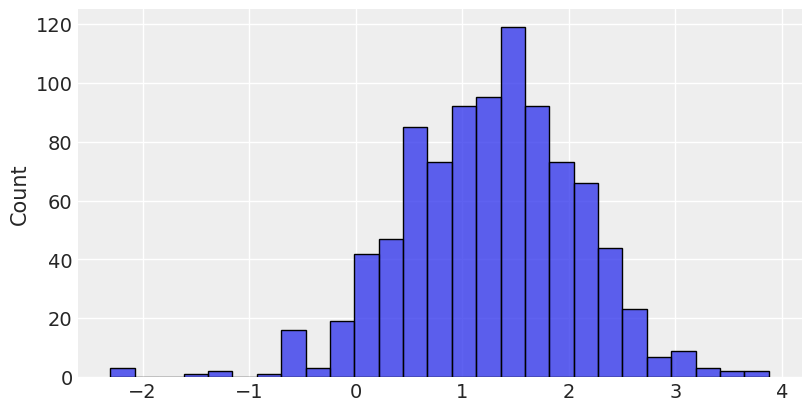

In [4]:
#Distribution of radon levels in MN (log scale):

sns.histplot(log_radon);

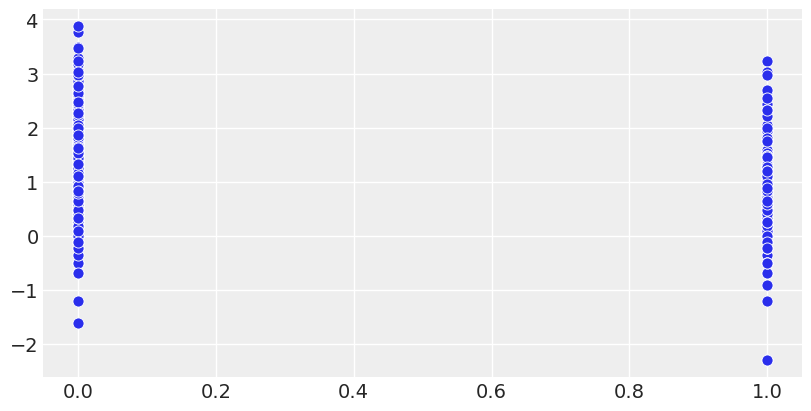

In [5]:
#as floor takes only 0 and 1 as values, we have data organized into two columns 
sns.scatterplot(floor, log_radon);

## Complete pooling

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

where:
* $y_i$: log-radon measured in the $i$-th household ($i$=1,2,...919)
* $x_i$: floor where radon has been measured in the $i$-th household ($i$=1,2,...919)
* $\alpha$ : intercept. If we standardize the data, this is the log-radon level in Minnesota, corresponding to a mean log-radon measure in the basement. In practice, this is the mean log-radon in Minnesota. 
* $\epsilon_i$ represents measurement error or random variation among houses.

## Probabilistic pooled model

To have a probabilistic model, we shall assign  prior to the parameters:

\begin{align}
\beta x_i & \sim N (0,1)  && \text{prior on the slope for standardized data} \\
\alpha &\sim N(0,1) && \text{prior on the intercept for standardized data} \\
\sigma_{\epsilon} &\sim \text{HalfNormal}(0,1) && \text{prior on the noise dev std,  for standardized y} \\
y_i  &\sim N( \alpha + \beta x_i,  \sigma_{\epsilon}) && \text{likelihood}
\end{align}

# No pooling:  an independent estimation of the intercept for each county

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$ index the different counties.

* $y_i$: log-radon measured in the $i$-th household ($i$=1,2,...919)
* $x_i$: floor of the $i$-th household ($i$=1,2,...919) where the measure has been taken (0 or 1)
* $\alpha_{j[i]}$ : intercept (different for each county; equal for all  households of the same county.
* The notation $\alpha_{j[i]}$ implies that household $i$ is in county $j$.

# No pooling:  an independent estimation of the intercept for each county

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

* The slope $\beta$ is equal for all counties; we assume that the difference between floor and basement does not depend on the county.
* On the other hand, the intercept does vary for each county. We can think of the intercept as the log-radon level for an average value of $x$, i.e., an average between floor and basement level for that county.

# Probabilistic unpooled model

We will fit, independently for each county,  the model: **REVISE**

\begin{align}
\beta x_i & \sim N (0,1)  && \text{prior on the slope for standardized data} \\
\alpha &\sim N(0,1) && \text{prior on the intercept for standardized data} \\
\sigma_{\epsilon} &\sim \text{HalfNormal}(0,1) && \text{prior on the noise dev std,  for standardized y} \\
y_i  &\sim N( \alpha + \beta x_i,  \sigma_{\epsilon}) && \text{likelihood}
\end{align}

# Discussion
Both approaches are extreme:

* pooling: we imply that all observations are samples from the same model,   ignoring any variation due to the county.
* unpooling: we imply that differences between counties are so large that each county needs its own model. We learn from scratch every model, without transferring any information between models.

# Complete pooling model (Bayesian)

In [9]:

with pm.Model() as pooled_model:
    #intercept is beta[0], slope is beta[1]. 
    #beta is a  vector of 2 parameters, as specified by  the shape parameter. 
    β = pm.Normal('β', 0, sigma=10, shape=2)
    σ = pm.HalfNormal('σ', 5)
    
    θ = β[0] + β[1]*floor_std
    
    y = pm.Normal('y', θ, sigma=σ, observed=log_radon_std)
    

In [10]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [21]:
# posterior mean of intercept and slope
# this is the way to access the trace, if the format is not inferenceData
a0, b0 = pooled_trace['β'].mean(axis=0)

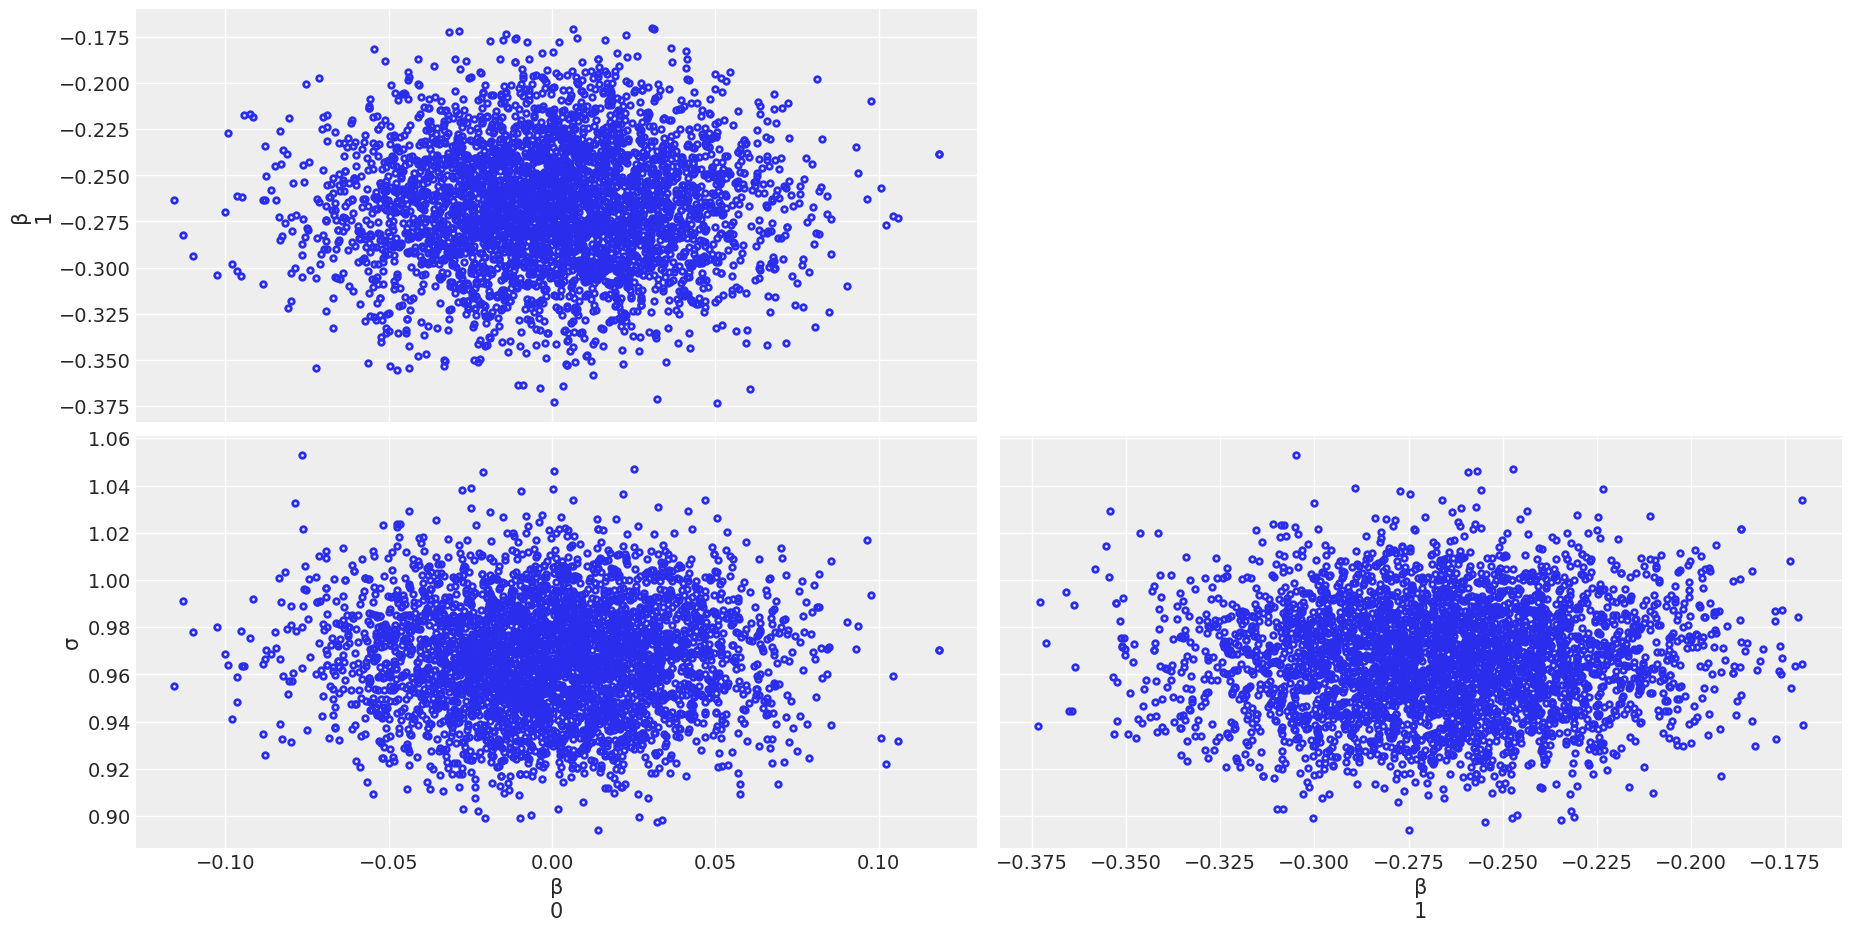

In [17]:
    #standardization of x removes correlation in the posterior.
with pooled_model:
        az.plot_pair(pooled_trace);

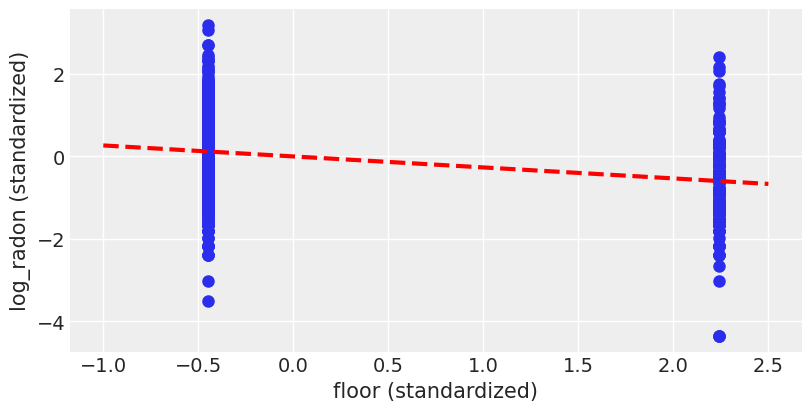

In [23]:
#plt.scatter(radon_data.floor, np.log(radon_data.activity+0.1))
plt.scatter(floor_std, log_radon_std)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b0*xvals + a0, 'r--')
plt.xlabel('floor (standardized)')
plt.ylabel('log_radon (standardized)');

Estimates of county radon levels for the unpooled model:

In [24]:
with pm.Model() as unpooled_model:
    # a different intercept for each county
    β0 = pm.Normal('β0', 0, sigma=10, shape=n_counties)

    # single slope
    β1 = pm.Normal('β1', 0, sigma=10)
    σ   = pm.HalfNormal('σ', 5)
    
    mu = β0[county] + β1*floor_std
    
    y = pm.Normal('y', mu, sigma=σ, observed=log_radon_std)
    

In [25]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β1, β0]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

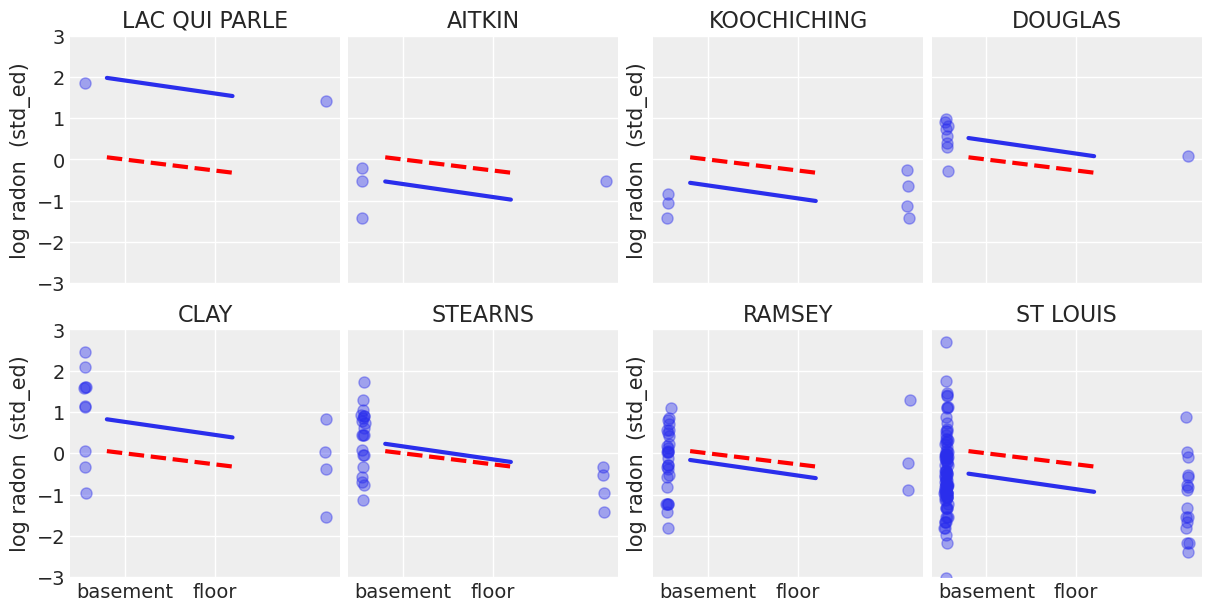

In [35]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

#posterior mean of the slope of the unpooled model. 
#The slope of the unpooled model is unique.
m = unpooled_trace['β1'].mean()

#one unpooled intercept for each county
unpooled_intercepts = pd.Series(unpooled_trace['β0'].mean(axis=0), index=counties)

for i,c in enumerate(sample_counties):
    y = log_radon_std[radon_data.county==c]
    x = floor_std[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # Unpooled intercept
    b = unpooled_intercepts[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, b0*xvals+a0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-3 ,3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon  (std_ed)')

Borh models are unsatisfactory:

* pooling is useless if we are trying to identify high-radon counties, 
* we do not trust extreme unpooled estimates produced by models using few observations, as in LAC QUI PARLE case.

# Multilevel models

* Multilevel models perform *partial pooling*: they provide a different estimate for each unit (county in our example)  pooling anyway information across units (counties), in order to produce better estimates for all units.

* They are appropriate when for instance you have:
    *  a set of individuals and more than one observation arises from the same individual (or location, or time)
        * to adjust estimates for imbalance in sampling, when some individuals are sampled more than others. Multivel allows to improve the estimates of the less sampled individuals, by exploiting information from the other individuals (*borrowing statistical strenght*).

#  Multilevel models

* For the moment, we only focus on the intercept.

* In the previous example, a hierarchical model would learn:
    * the population of households in each county, characterized by a common intercept;
    * the population of intercepts (one sample for each county).
    


#  Multilevel models


* The distribution of intercept in the population becomes the prior for the intercepts each county;  this prior is however  learned from data. 

*  We thus  tracks the mean and standard deviation of the intercept of  each county *and*  two parameters to describe the population of intercepts: their average and their standard deviation.

#  Multilevel models


* If the population of intercepts is  highly variable,  the distribution of the intercepts  over counties  uninformative.
* Thus the prior for each county is uninformative.
* In this case,  the observations at any one county  will not impact  the estimate of another county.
* If instead the population of the intercepts  contains little variation, the prior is narrow and highly informative. 
* Estimates for the counties with limited number of observation will benefit by such informative prior.  Observation at any county will have an  impact on estimates also in  other counties, by impacting the prior.

# Varying intercept model

* We want a  model, in which we simultaneously estimate  an intercept for each county and how the intercept varies across counties.
* A *varying intercept* model is as follows:
    * for each county, it uses a different intercept 
    *  it learns  the prior that is common to all of these intercepts, i.e., the population of intercepts.
  

# continuare seguendo statistical rethinking

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [50]:
with pm.Model() as partial_pooling:
    
    # Priors
    μ_a = pm.Normal('μ_a', mu=0., sigma=10)
    σ_a = pm.HalfCauchy('σ_a', 5)
    
    # Random intercepts
    a = pm.Normal('a', mu=μ_a, sigma=σ_a, shape=n_counties)
    
    # Model error
    σ_y = pm.HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a[county]
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon_std)
    

In [51]:
with partial_pooling:
    partial_pooling_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_y, a, σ_a, μ_a]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


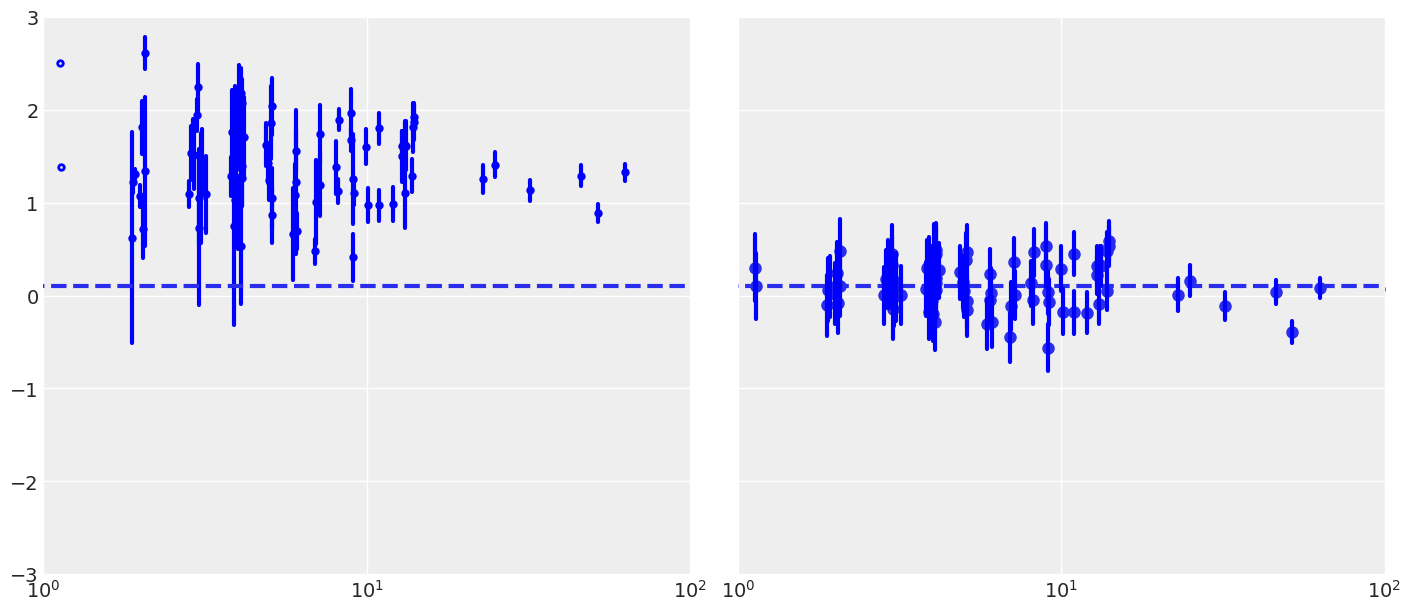

In [53]:
sample_trace = partial_pooling_trace['a']

fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
n_samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties)

n_county = radon_data.groupby('county')['county_code'].count()
unpooled_means = radon_data.groupby('county')['log_radon'].mean()
unpooled_sd = radon_data.groupby('county')['log_radon'].std()
unpooled = pd.DataFrame({'n':n_county, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

axes[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

        
n_samples, n_counties = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
axes[1].scatter(n_county.values + jitter, means)
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(-3, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+j]*2, [m-s, m+s], 'b-');

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept, fixed slope

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [68]:
az.waic (pooled_trace)
az.compare({'model_p':pooled_trace, 'model_u': unpooled_trace,  'model_h':partial_pooling_trace, 'model_h2':varying_intercept_trace}, ic='waic')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_h2,0,-1036.750476,49.323317,0.000000,1.000000e+00,28.016044,0.000000,True,log
model_u,1,-1241.871614,82.395791,205.121139,0.000000e+00,28.206901,6.037335,True,log
model_h,2,-1267.122581,44.396155,230.372105,0.000000e+00,28.776404,10.762809,True,log
model_p,3,-1273.574933,3.837079,236.824457,2.351896e-10,24.979167,10.769506,False,log


In [64]:
with pm.Model() as varying_intercept:
    
    # Priors
    μ_a = pm.Normal('μ_a', mu=0., sigma=10)
    σ_a = pm.HalfCauchy('σ_a', 5)
    
    
    # Random intercepts
    a = pm.Normal('a', mu=μ_a, sigma=σ_a, shape=n_counties)
    # Common slope
    b = pm.Normal('b', mu=0., sigma=10)
    
    # Model error
    sd_y = pm.HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = a[county] + b * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_radon)
    

In [67]:
with varying_intercept:
    varying_intercept_trace = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_y, b, a, σ_a, μ_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [ ]:
(ax,) = plot_forest(varying_intercept_trace, var_names=['a'])
ax.set_yticklabels([""]);

In [ ]:
from arviz import plot_posterior

plot_posterior(varying_intercept_trace, var_names=['σ_a', 'b']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [ ]:
from pymc3 import summary

summary(varying_intercept_trace, var_names=['b'])

In [ ]:
xvals = np.arange(2)
bp = varying_intercept_trace[a].mean(axis=0)
mp = varying_intercept_trace[b].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = radon_data.log_radon[radon_data.county==c]
    x = radon_data.floor[radon_data.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    m = unpooled_trace['β1'].mean()
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level');

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [ ]:
with Model() as varying_slope:
    
    # Priors
    μ_b = Normal('μ_b', mu=0., sigma=10)
    σ_b = HalfCauchy('σ_b', 5)
    
    # Common intercepts
    a = Normal('a', mu=0., sigma=10)
    # Random slopes
    b = Normal('b', mu=μ_b, sigma=σ_b, shape=n_counties)
    
    # Model error
    σ_y = HalfCauchy('σ_y',5)
    
    # Expected value
    y_hat = a + b[county] * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with varying_slope:
    varying_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
(ax,) = plot_forest(varying_slope_trace, var_names=['b'])
ax.set_yticklabels([""]);

In [ ]:
xvals = np.arange(2)
b = varying_slope_trace['a'].mean()
m = varying_slope_trace['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

## Exercise: Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$

Combine these two models to create a version with both slope and intercept varying.

In [ ]:
with Model() as varying_intercept_slope:
    
    # Write your model here

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

Forest plot of slopes and intercepts:

In [ ]:
plot_forest(varying_intercept_slope_trace, var_names=['a','b']);

In [ ]:
xvals = np.arange(2)
b = varying_intercept_slope_trace['a'].mean(axis=0)
m = varying_intercept_slope_trace['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [ ]:
from pymc3 import Deterministic

with Model() as hierarchical_intercept:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model
    γ_0 = Normal('γ_0', mu=0., sigma=10)
    γ_1 = Normal('γ_1', mu=0., sigma=10)
    
    
    # Uranium model for intercept
    μ_a = γ_0 + γ_1*log_uranium
    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])
    
    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with hierarchical_intercept:
    hierarchical_intercept_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
a_means = hierarchical_intercept_trace['a'].mean(axis=0)
plt.scatter(log_uranium, a_means)
g0 = hierarchical_intercept_trace['γ_0'].mean()
g1 = hierarchical_intercept_trace['γ_1'].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

a_se = hierarchical_intercept_trace['a'].std(axis=0)
for ui, m, se in zip(log_uranium, a_means, a_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate');

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [ ]:
# Create new variable for mean of floor across counties
xbar = radon_data.groupby('county')['floor'].mean().rename(county_lookup).values

In [ ]:
with Model() as contextual_effect:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    

In [ ]:
with contextual_effect:
    contextual_effect_trace = sample(1000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
plot_forest(contextual_effect_trace, var_names=['γ']);

In [ ]:
summary(contextual_effect_trace, var_names=['γ'])

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [ ]:
county_lookup['ST LOUIS']

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is a matter of adding a single additional line in PyMC:

In [ ]:
with Model() as contextual_pred:
    
    # Priors
    σ_a = HalfCauchy('σ_a', 5)
    
    # County uranium model for slope
    γ = Normal('γ', mu=0., sigma=10, shape=3)
    
    # Uranium model for intercept
    μ_a = Deterministic('μ_a', γ[0] + γ[1]*log_uranium + γ[2]*xbar[county])

    # County variation not explained by uranium
    ϵ_a = Normal('ϵ_a', mu=0, sigma=1, shape=n_counties)
    a = Deterministic('a', μ_a + σ_a*ϵ_a[county])

    # Common slope
    b = Normal('b', mu=0., sigma=10)
    
    # Model error
    σ_y = Uniform('σ_y', lower=0, upper=100)
    
    # Expected value
    y_hat = a + b * floor_measure
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=σ_y, observed=log_radon)
    
    # St Louis county prediction
    stl_pred = Normal('stl_pred', mu=a[69] + b, sigma=σ_y)
    

In [ ]:
with contextual_pred:
    contextual_pred_trace = sample(2000, tune=1000, cores=2, random_seed=RANDOM_SEED)

In [ ]:
plot_posterior(contextual_pred_trace, var_names=['stl_pred']);

## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [ ]:
# Write your answer here

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.